# Figure 4
The aim here is to explore what, if any, biases in estimation occur when the observer actually discounts according to the modified Rachlin function, but we fit their choice data using the hyperbolic discount function.

The key point here is that fitting data with the hyperbolic is equivalent to fitting with the modified Rachling _but_ assuming linear objective time is being discounted (i.e. $s=1$). But when this is not true (i.e. when $s \neq 1$) then we are likely to see biases in our estimates of $k$. So we will try to charachterise these biases.

So we are going to end up with a plot where:
- x-axis = true discount rate, $\kappa$ (from the modified Rachlin function).
- y-axis = error in estimated discount rate $k$ from the hyperbolic discount function.
- Each point will be a simulated experiment
- Points are color coded by true value of $s$.

In [1]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np

%config InlineBackend.figure_format = 'retina'

import sys
print("Python version:\n{}\n".format(sys.version))

Python version:
3.6.6 |Anaconda custom (64-bit)| (default, Jun 28 2018, 11:07:29) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]



Set the random seed, for reproducibility

In [2]:
np.random.seed(seed=353485)

Import my functions

In [3]:
from model import get_response, calc_log_likelihood
from discount_functions import rachlin, rachlin_kappa, hyperbolic_k
from fitting import MLE_procedure
from adaptive_experiment import make_dataset, plot_data

# my own custom plot options
%run set_plot_options.py

# Down to business...
Define all inputs parameters to this notebook

In [4]:
N_simulated_people_per_S_level = 300

# define a range of true kappa values, uniformly distributed in log space
kappa_true = np.logspace(-4, -1, N_simulated_people_per_S_level)

# define true s parameter values, also a set of corresponding colours for plotting purposes.
s_true = [0.6, 0.8, 1.0, 1.25, 1.5]
cols = ['C0', 'C1', 'C2', 'C3', 'C4']

We have a set of true $s$ and a set of true $log(k)$ values. What we want is a corresponding set of estimated $log(k)$ values frrom the hyperbolic discount function fitting.

In [5]:
def many_simulations(s_true, kappa_true):
    k_ml = []
    for kappa in kappa_true:
        data = make_dataset(rachlin_kappa, [s_true, kappa])
        # we are defining this here, repeatedly because we are binding 
        # `data` to the local scope of the function
        def nll_func_hyperbolic(params):
            return -calc_log_likelihood(data, hyperbolic_k, params)
        fit = MLE_procedure(nll_func_hyperbolic, [(0,5)])
        k_ml.append(fit.x[0])
    return k_ml

In [6]:
estimated_k = [many_simulations(s, kappa_true) for s in s_true]

This will result in `estimated_k` being a list of lists. At the top level we have a list where one entry is one level of $s$. Each list within is a set of actual estimated `estimated_k` values.

## Plotting

In [7]:
def proportional_error(kappa_true, k_recov):
    return (k_recov-kappa_true)/kappa_true

Text(0,0.5,'$f(D)$')

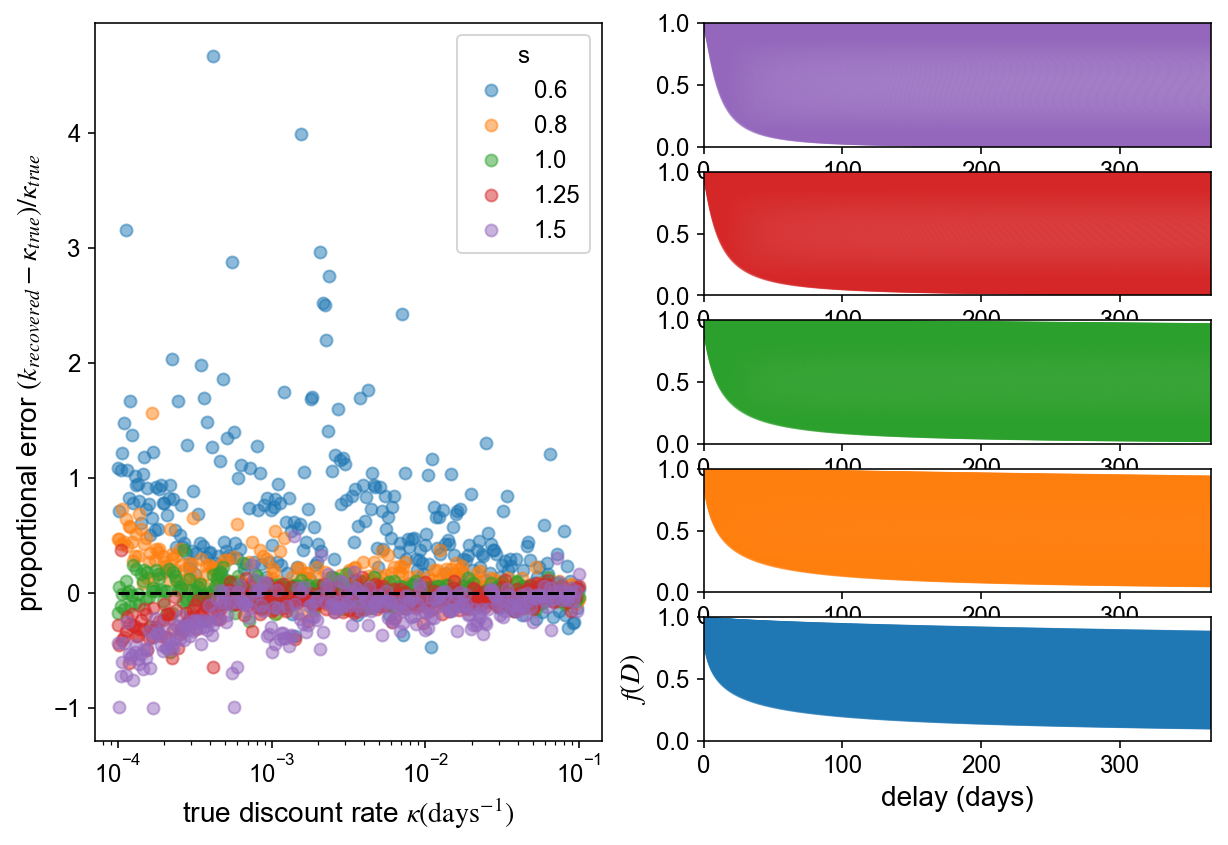

In [8]:
fig1 = plt.figure(figsize=(FIG_WIDTH_INCHES, FIG_WIDTH_INCHES*0.66))

subplot_size = (len(s_true), 2)

# main plot ------------------------------------------------------
ax = plt.subplot2grid(subplot_size, (0, 0), rowspan=len(s_true))
# scatter, colour coded by s_true
for k_recov, s in zip(estimated_k, s_true):
    ax.plot(kappa_true, proportional_error(kappa_true, k_recov), 'o', label=s, alpha=0.5)


# line of zero errpr
ax.plot([min(kappa_true), max(kappa_true)],
        [0, 0],
        ls="--", c='k')

ax.set_xscale('log')
ax.set_xlabel(r'true discount rate $\kappa (\rm{days}^{-1})$')
ax.set_ylabel(r'proportional error $(k_{recovered}-\kappa_{true})/\kappa_{true}$')
ax.legend(title="s")

# plot true discount functions -----------------------------------
axdf = [plt.subplot2grid(subplot_size, (s, 1)) for s in range(len(s_true))]
delays = np.linspace(0, 365, 1000)
for ax, s, col in zip(reversed(axdf), s_true, cols):
    for kappa in kappa_true:
        df = rachlin_kappa(delays, [s, kappa])
        ax.plot(delays, df, alpha=0.5, color=col)
        ax.set_xlim([0, 365])
        ax.set_ylim([0, 1])
    
axdf[-1].set_xlabel('delay (days)')
axdf[-1].set_ylabel(r'$f(D)$')

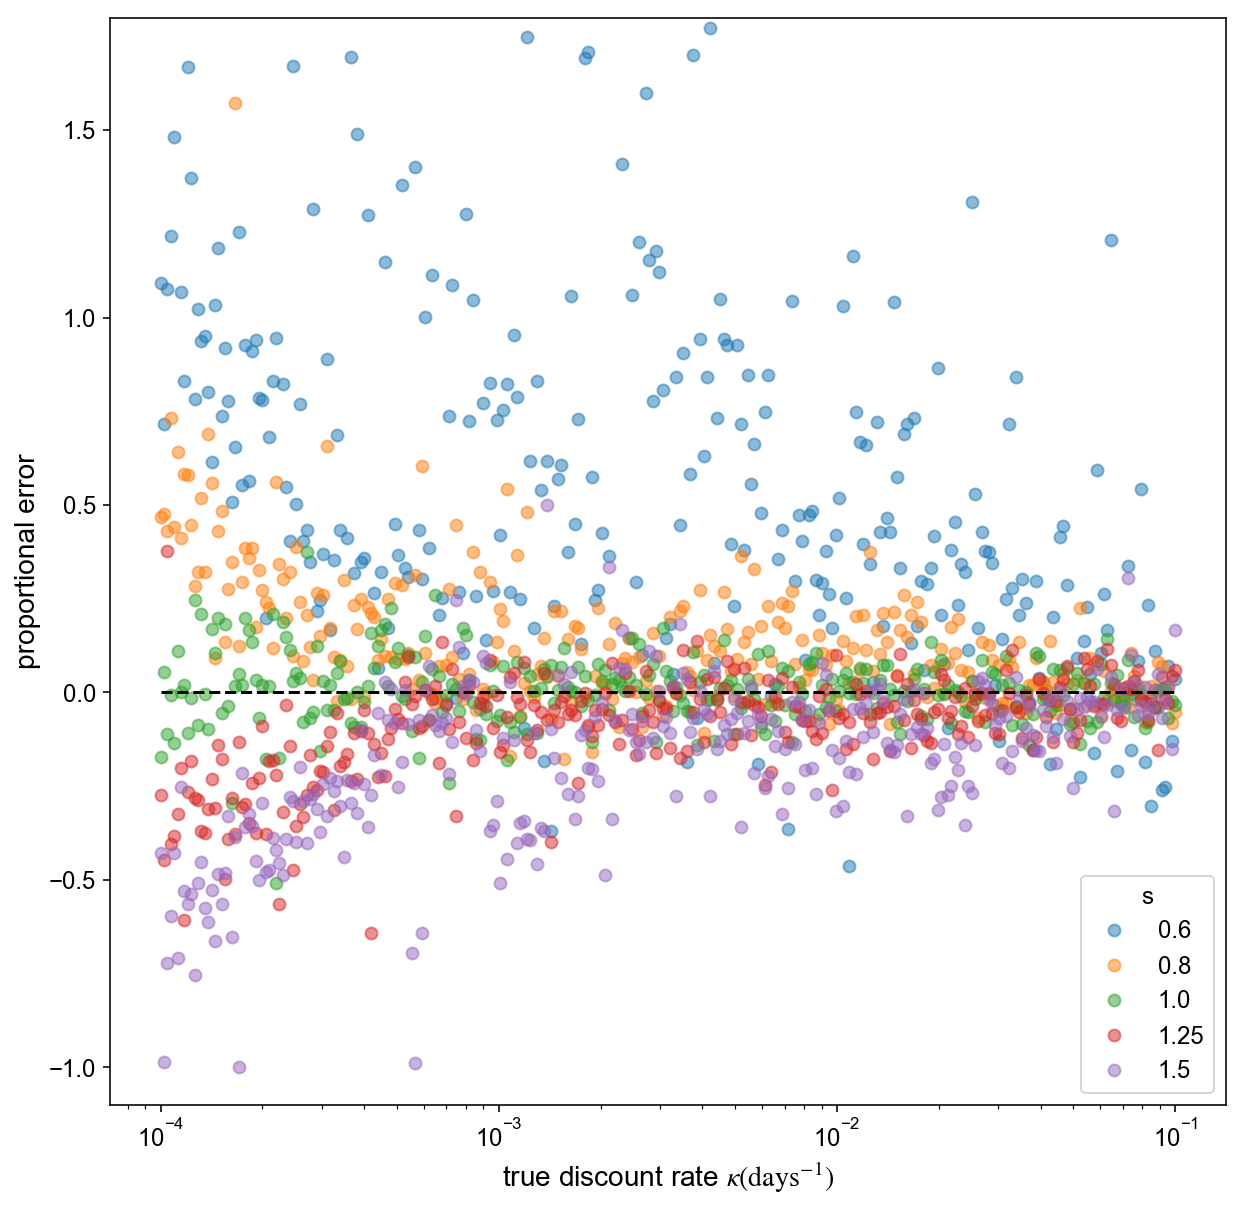

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(FIG_WIDTH_INCHES, FIG_WIDTH_INCHES))

# main plot ------------------------------------------------------

# scatter, colour coded by s_true
for k_recov, s in zip(estimated_k, s_true):
    ax.plot(kappa_true, proportional_error(kappa_true, k_recov), 'o', label=s, alpha=0.5)

# line of zero errpr
ax.plot([min(kappa_true), max(kappa_true)],
        [0, 0],
        ls="--", c='k')

ax.set_xscale('log')
ax.set_ylim([-1.1, 1.8])
ax.set_xlabel(r'true discount rate $\kappa (\rm{days}^{-1})$')
ax.set_ylabel(r'proportional error')
ax.legend(title="s")

fig.savefig("Figure4.pdf", bbox_inches='tight', dpi=300)

## CHECKING
Do some manual checks to ensure that there is in fact no bias for $s>1$.
Do manual fits and plotting.

In [10]:
def visualise_true_and_fit(true_s_kappa):
    
    data = make_dataset(rachlin_kappa, true_s_kappa)

    def nll_func_hyperbolic(params):
        return -calc_log_likelihood(data, hyperbolic_k, params)

    fit = MLE_procedure(nll_func_hyperbolic, [(0,5)])
    estimated_k = fit.x[0]

    # plot data, true df, and estimated
    fig, ax = plt.subplots()
    plot_data(data, ax)
    
    print('plotting now')

    delays = np.logspace(-2, 4, 1_000)
    ax.plot(delays, rachlin_kappa(delays, true_s_kappa), label='true discount function')
    ax.plot(delays, hyperbolic_k(delays, estimated_k), label='estimated hyperbolic df')
    ax.legend()
    ax.set_xscale('log')

plotting now


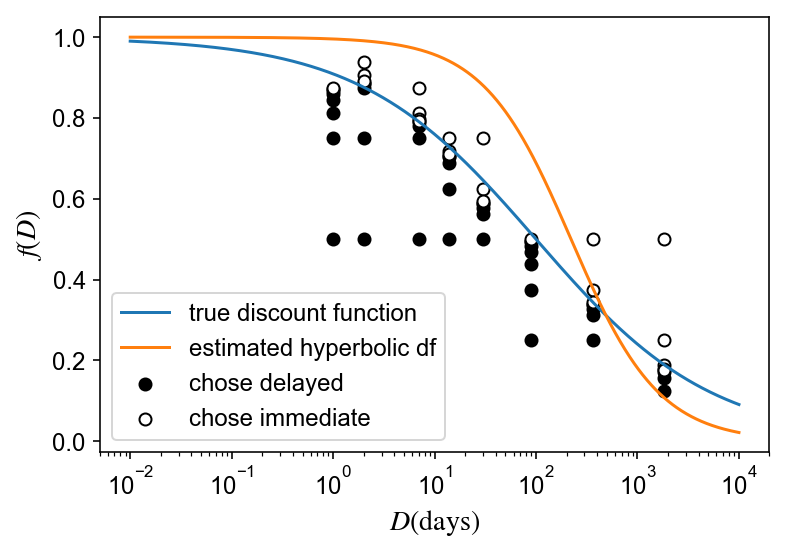

In [11]:
visualise_true_and_fit([0.5, 0.01])

plotting now


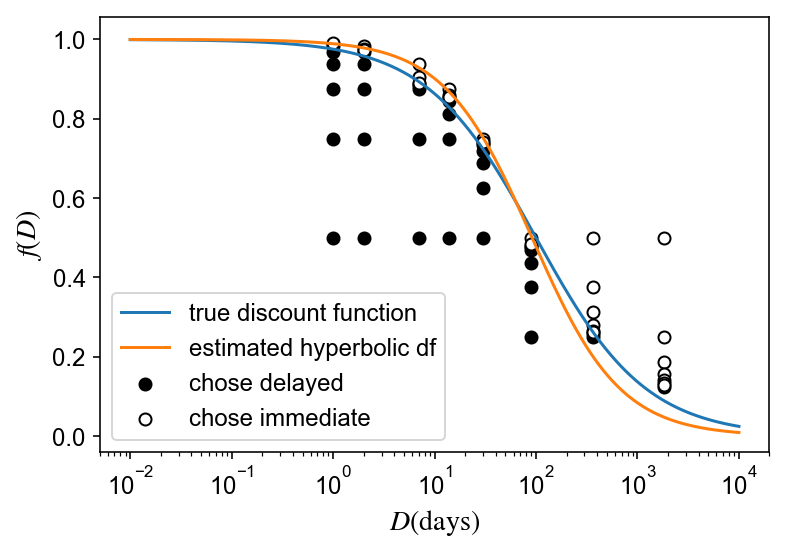

In [12]:
visualise_true_and_fit([0.8, 0.01])

plotting now


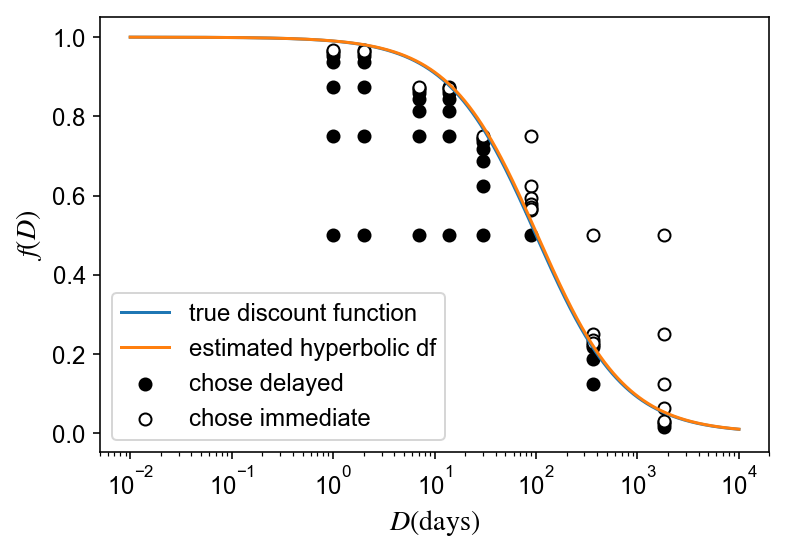

In [13]:
visualise_true_and_fit([1, 0.01])

plotting now


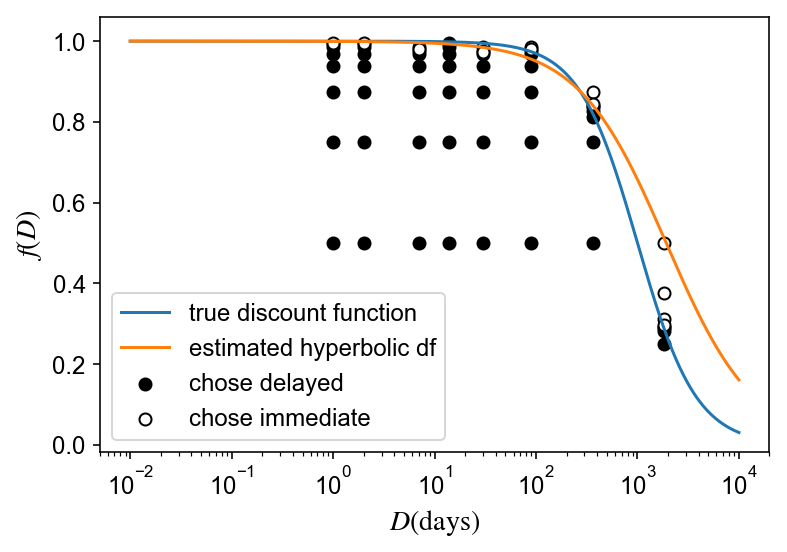

In [14]:
visualise_true_and_fit([1.5, 0.001])

plotting now


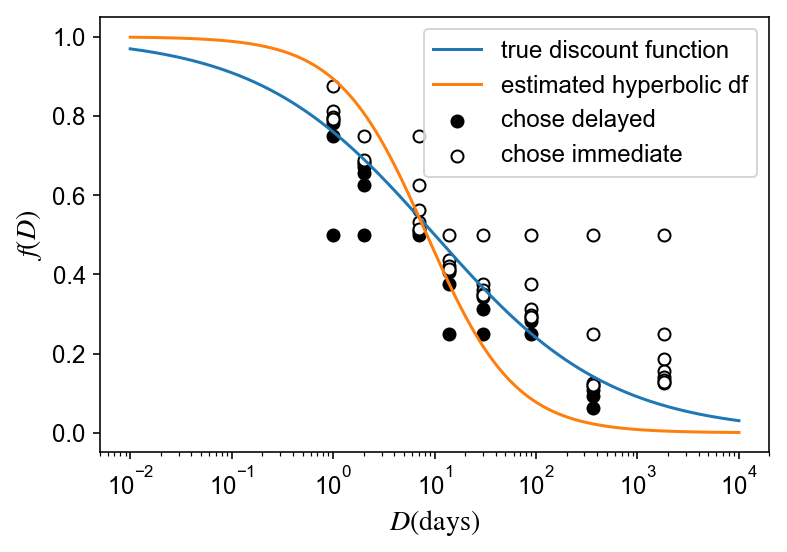

In [15]:
visualise_true_and_fit([0.5, 0.1])

# Interpretation
It looks as if:
- for $s<1$ we are getting systematic bias (overestimates) of hyperbolic $k$.
- for $s=1$ we do not get any bias in estimates, which makes sense as we are fitting an effectively hyperbolic discounter with a hyperbolic function.
- for $s>1$ we are not getting systematic bias for estimates of of hyperbolic $k$.

We also get high levels of variation in estimation error for $s<1$. I believe this is a product of the adaptive experimental design we are using... the intuition is that the estimation bias would be more consistent (less variable) but this seems to not be the case.
